Guide ITK: https://itk.org/ItkSoftwareGuide.pdf

In [19]:
import itk
print(itk.Version.GetITKVersion())

5.4.0


Guide VTK : https://vtk.org/wp-content/uploads/2021/08/VTKUsersGuide.pdf

In [1]:
import vtk
print(vtk.__version__)

9.3.0


In [4]:
import matplotlib.pyplot as plt

In [31]:
import numpy as np

In [4]:
# renderWindowInteractor.SetInteractorStyle(vtk.vtkInteractorStyleImage())

## Image Registration

In [5]:
fixed_filepath = "./Data/case6_gre1.nrrd"
moving_filepath = "./Data/case6_gre2.nrrd"
register_filepath = "./Data/register_image.nrrd"

In [6]:
PixelType = itk.ctype('unsigned short')
fixed_image = itk.imread(fixed_filepath, PixelType)
moving_image = itk.imread(moving_filepath, PixelType)
register_image = itk.imread(register_filepath, PixelType)

In [7]:
fixed_image.shape, moving_image.shape, register_image.shape

((176, 256, 256), (176, 256, 256), (176, 256, 256))

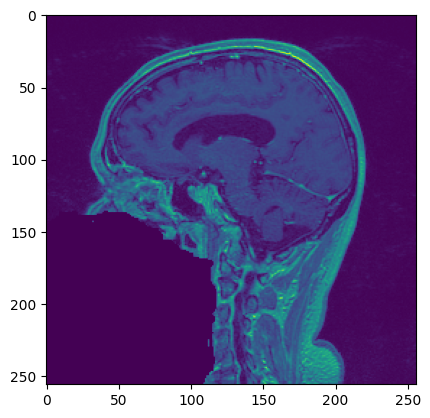

In [8]:
plt.imshow(fixed_image[100, :, :])

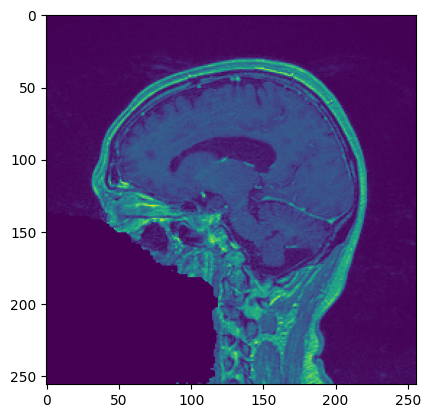

In [9]:
plt.imshow(moving_image[100, :, :])

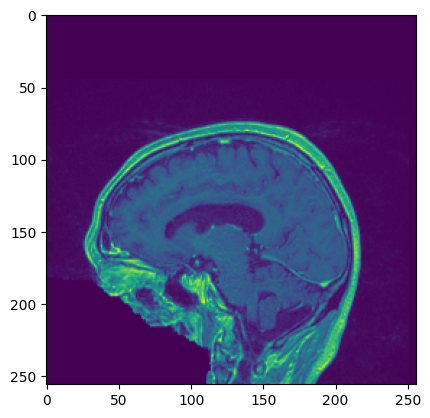

In [10]:
plt.imshow(register_image[100, :, :])

In [7]:
InputPixelType = itk.US
OutputPixelType = itk.F

InputImageType = itk.Image[InputPixelType, 3]
OutputImageType = itk.Image[OutputPixelType, 3]

In [8]:
CastFilterType = itk.CastImageFilter[InputImageType, OutputImageType]
castFilter = CastFilterType.New()
castFilter.SetInput(fixed_image)
castFilter.Update()
fixed_image_float = castFilter.GetOutput()

In [9]:
castFilter = CastFilterType.New()
castFilter.SetInput(moving_image)
castFilter.Update()
moving_image_float = castFilter.GetOutput()

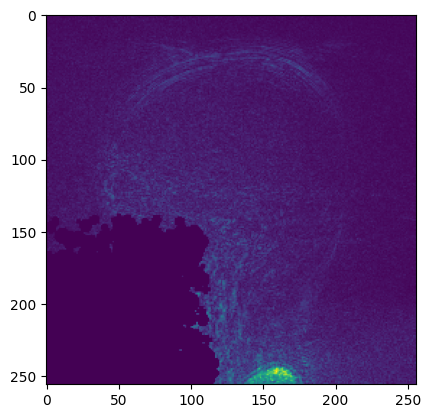

In [10]:
plt.imshow(fixed_image_float[0, :, :])

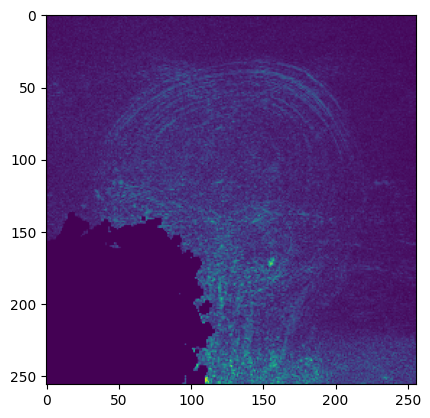

In [11]:
plt.imshow(moving_image_float[0, :, :])
# plt.imshow(moving_image_float[0, :, :] - fixed_image_float[0, :, :])

In [12]:
# NormalizeFilterType = itk.NormalizeImageFilter[InputImageType, OutputImageType]
# normalizeFilter = NormalizeFilterType.New()
# normalizeFilter.SetInputData(fixed_image)
# normalizeFilter.Update()

In [13]:
dimension = fixed_image_float.GetImageDimension()
FixedImageType = OutputImageType
MovingImageType = OutputImageType

In [14]:
TransformType = itk.AffineTransform[itk.D, 3]
initialTransform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New()

optimizer.SetLearningRate(4)
optimizer.SetMinimumStepLength(0.001)
optimizer.SetNumberOfIterations(200)

metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

Registration = itk.ImageRegistrationMethodv4[OutputImageType, OutputImageType]
registration = Registration.New(FixedImage=fixed_image_float, MovingImage=moving_image_float, Metric=metric,
                                                 Optimizer=optimizer, InitialTransform=initialTransform)

In [15]:
moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
initial_parameters[0] = 0
initial_parameters[1] = 0
initial_parameters[2] = 0
moving_initial_transform.SetParameters(initial_parameters)

In [16]:
# Set the scales
scale_parameters = moving_initial_transform.GetParameters()
scale_parameters[0] = 1000
scale_parameters[1] = 1
scale_parameters[2] = 1
optimizer.SetScales(scale_parameters)

In [17]:
registration.SetMovingInitialTransform(moving_initial_transform)

# Set the center of the image
fixed_parameters = moving_initial_transform.GetFixedParameters()
fixed_parameters[0] = moving_image.GetLargestPossibleRegion().GetSize()[0] / 2.0
fixed_parameters[1] = moving_image.GetLargestPossibleRegion().GetSize()[1] / 2.0
# fixed_parameters[2] = moving_image.GetLargestPossibleRegion().GetSize()[2] / 2.0

moving_initial_transform.SetFixedParameters(fixed_parameters)

In [18]:
identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)
registration.SetNumberOfLevels(1)

In [35]:
# registration.Update()

In [24]:
transform = registration.GetTransform()
final_parameters = transform.GetParameters()
angle = final_parameters.GetElement(0)
translation_along_x = final_parameters.GetElement(1)
translation_along_y = final_parameters.GetElement(2)
# translation_along_z = final_parameters.GetElement(3)

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result = ")
print(" Angle = " + str(angle))
print(" Translation X = " + str(translation_along_x))
print(" Translation Y = " + str(translation_along_y))
# print(" Translation Z = " + str(translation_along_z))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result = 
 Angle = nan
 Translation X = nan
 Translation Y = nan
 Iterations    = 200
 Metric value  = 1.7976931348623157e+308


In [ ]:
CompositeTransformType = itk.CompositeTransform[itk.D, dimension]
output_composite_transform = CompositeTransformType.New()
output_composite_transform.AddTransform(moving_initial_transform)
output_composite_transform.AddTransform(registration.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input=moving_image, Transform=transform, UseReferenceImage=True,
                                        ReferenceImage=fixed_image)
resampler.SetDefaultPixelValue(100)

subtraction = itk.SubtractImageFilter(Input1=fixed_image, Input2=resampler)
plt.ion()
plt.imshow(itk.GetArrayViewFromImage(subtraction))
plt.waitforbuttonpress()

OutputPixelType = itk.ctype('unsigned char')
OutputImageType = itk.Image[OutputPixelType, dimension]
caster = itk.CastImageFilter[FixedImageType, OutputImageType].New(resampler)

itk.imwrite(caster, output_filepath)

## Trying with 3D viewer

In [3]:
nrrdReader = vtk.vtkNrrdReader()
nrrdReader.SetFileName("./Data/case6_gre1.nrrd")
nrrdReader.Update()

https://stackoverflow.com/a/56765160

In [4]:
# Calculate the center of the volume
(xMin, xMax, yMin, yMax, zMin, zMax) = nrrdReader.GetExecutive().GetWholeExtent(nrrdReader.GetOutputInformation(0))
(xSpacing, ySpacing, zSpacing) = nrrdReader.GetOutput().GetSpacing()
(x0, y0, z0) = nrrdReader.GetOutput().GetOrigin()

center = [x0 + xSpacing * 0.5 * (xMin + xMax),
          y0 + ySpacing * 0.5 * (yMin + yMax),
          z0 + zSpacing * 0.5 * (zMin + zMax)]

In [5]:
# Matrices for sagittal, axial, coronal view orientations
sagittal = vtk.vtkMatrix4x4()
sagittal.DeepCopy((1, 0, 0, center[0],
                   0,-1, 0, center[1],
                   0, 0, 1, center[2],
                   0, 0, 0, 1))

axial = vtk.vtkMatrix4x4()
axial.DeepCopy((0, 1, 0, center[0],
                0, 0, 1, center[1],
                1, 0, 0, center[2],
                0, 0, 0, 1))

coronal = vtk.vtkMatrix4x4()
coronal.DeepCopy(( 0, 0, 1, center[0],
                   0,-1, 0, center[1],
                  -1, 0, 0, center[2],
                   0, 0, 0, 1))

In [7]:
# Extract a slice in the desired orientation
reslice = vtk.vtkImageReslice()
reslice.SetInputConnection(nrrdReader.GetOutputPort())
reslice.SetOutputDimensionality(2)
reslice.SetResliceAxes(sagittal) # Change view here (axial, sagittal, coronal)
reslice.SetInterpolationModeToLinear()

In [8]:
# Create a greyscale lookup table
table = vtk.vtkLookupTable()
table.SetRange(0, 1500) # image intensity range
table.SetValueRange(0.0, 1.0) # from black to white
table.SetSaturationRange(0.0, 0.0) # no color saturation
table.SetRampToLinear()
table.Build()

In [9]:
# Map the image through the lookup table
color = vtk.vtkImageMapToColors()
color.SetLookupTable(table)
color.SetInputConnection(reslice.GetOutputPort())

In [10]:
# Display the image
actor = vtk.vtkImageActor()
actor.GetMapper().SetInputConnection(color.GetOutputPort())

renderer = vtk.vtkRenderer()
renderer.AddActor(actor)

window = vtk.vtkRenderWindow()
window.AddRenderer(renderer)

In [11]:
# Set up the interaction
interactorStyle = vtk.vtkInteractorStyleImage()
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetInteractorStyle(interactorStyle)
window.SetInteractor(interactor)
window.Render()

In [12]:
# Create callbacks for slicing the image
actions = {}
actions["Slicing"] = 0

def ButtonCallback(obj, event):
    if event == "LeftButtonPressEvent":
        actions["Slicing"] = 1
    else:
        actions["Slicing"] = 0

def MouseMoveCallback(obj, event):
    (lastX, lastY) = interactor.GetLastEventPosition()
    (mouseX, mouseY) = interactor.GetEventPosition()
    if actions["Slicing"] == 1:
        deltaY = mouseY - lastY
        reslice.Update()
        sliceSpacing = reslice.GetOutput().GetSpacing()[2]
        matrix = reslice.GetResliceAxes()
        # move the center point that we are slicing through
        center = matrix.MultiplyPoint((0, 0, sliceSpacing * deltaY, 1))
        matrix.SetElement(0, 3, center[0])
        matrix.SetElement(1, 3, center[1])
        matrix.SetElement(2, 3, center[2])
        window.Render()
    else:
        interactorStyle.OnMouseMove()

interactorStyle.AddObserver("MouseMoveEvent", MouseMoveCallback)
interactorStyle.AddObserver("LeftButtonPressEvent", ButtonCallback)
interactorStyle.AddObserver("LeftButtonReleaseEvent", ButtonCallback)

6

In [13]:
# Start interaction
interactor.Start()
del renderer
del window
del interactor

## Metrics for visualisation

In [102]:
def get_number_of_tumored_pixels(slice1, slice2):
    print(np.unique(slice1))
    print(np.unique(slice2))

In [9]:
image_base1= itk.imread("./Data/case6_gre1.nrrd")
image_base2 = itk.imread("./Data/case6_gre2_registered_rigid.nrrd")

In [10]:
image_seg1 = itk.imread("./Data/case6_gre1_result.nrrd")
image_seg2 = itk.imread("./Data/case6_gre2_result.nrrd")
image_seg1.shape, image_seg2.shape

((176, 256, 256), (176, 256, 256))

In [11]:
images = [image_base1, image_base2, image_seg1, image_seg2]
def show(slice_number):
    fig = plt.figure(figsize=(10, 10))
    columns = 2
    rows = len(images) // columns + 1
    for i in range(0, len(images)):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(images[i][slice_number, :, :])
    plt.show()

In [12]:
from ipywidgets import widgets, IntSlider, interact, Layout

In [13]:
slice_slider = widgets.IntSlider(min=0, max=176, step=1, value=81,
                                 description='Slice number', continuous_update=False, layout=Layout(width="800px"))

interact(show, slice_number=slice_slider)
# from 71 to 86

interactive(children=(IntSlider(value=81, continuous_update=False, description='Slice number', layout=Layout(w…

<function __main__.show(slice_number)>

## Displaying 2 images

https://stackoverflow.com/a/56765160

### First image

In [66]:
nrrdReader1 = vtk.vtkNrrdReader()
nrrdReader1.SetFileName("./Data/case6_gre1.nrrd")
# nrrdReader1.SetFileName("./Data/case6_gre1_result.nrrd")
nrrdReader1.Update()

In [67]:
# Calculate the center of the volume
(xMin1, xMax1, yMin1, yMax1, zMin1, zMax1) = nrrdReader1.GetExecutive().GetWholeExtent(nrrdReader1.GetOutputInformation(0))
(xSpacing1, ySpacing1, zSpacing1) = nrrdReader1.GetOutput().GetSpacing()
(x01, y01, z01) = nrrdReader1.GetOutput().GetOrigin()

center1 = [x01 + xSpacing1 * 0.5 * (xMin1 + xMax1),
          y01 + ySpacing1 * 0.5 * (yMin1 + yMax1),
          z01 + zSpacing1 * 0.5 * (zMin1 + zMax1)]

In [68]:
# Matrices for sagittal, axial, coronal view orientations
sagittal1 = vtk.vtkMatrix4x4()
sagittal1.DeepCopy((1, 0, 0, center1[0],
                    0,-1, 0, center1[1],
                    0, 0, 1, center1[2],
                    0, 0, 0, 1))

axial1 = vtk.vtkMatrix4x4()
axial1.DeepCopy((0, 1, 0, center1[0],
                 0, 0, 1, center1[1],
                 1, 0, 0, center1[2],
                 0, 0, 0, 1))

coronal1 = vtk.vtkMatrix4x4()
coronal1.DeepCopy(( 0, 0, 1, center1[0],
                    0,-1, 0, center1[1],
                   -1, 0, 0, center1[2],
                    0, 0, 0, 1))

In [ ]:
def create_red_lookup_table():
    lut = vtk.vtkLookupTable()
    lut.SetNumberOfTableValues(2)
    lut.SetTableValue(0, 0.0, 0.0, 0.0, 0.0)  # Background: transparent
    lut.SetTableValue(1, 1.0, 0.0, 0.0, 0.5)  # Tumor: red with opacity
    lut.Build()
    return lut

In [69]:
# Extract a slice in the desired orientation
reslice1 = vtk.vtkImageReslice()
reslice1.SetInputConnection(nrrdReader1.GetOutputPort())
reslice1.SetOutputDimensionality(2)
reslice1.SetResliceAxes(sagittal1) # Change view here (axial, sagittal, coronal)
# reslice1.SetInterpolationModeToLinear()

In [70]:
# Create a greyscale lookup table
table1 = vtk.vtkLookupTable()
table1.SetRange(0, 500) # image intensity range (0 1500)
table1.SetValueRange(0.0, 1.0) # from black to white
table1.SetSaturationRange(0.0, 0.0) # no color saturation
table1.SetRampToLinear()
table1.Build()

In [71]:
# Map the image through the lookup table
color1 = vtk.vtkImageMapToColors()
color1.SetLookupTable(table1)
color1.SetInputConnection(reslice1.GetOutputPort())
color1.Update()

### Second image

In [72]:
nrrdReader2 = vtk.vtkNrrdReader()
nrrdReader2.SetFileName("./Data/case6_gre2_registered_rigid.nrrd")
# nrrdReader2.SetFileName("./Data/case6_gre2_result.nrrd")
nrrdReader2.Update()

In [73]:
# Calculate the center of the volume
(xMin2, xMax2, yMin2, yMax2, zMin2, zMax2) = nrrdReader2.GetExecutive().GetWholeExtent(nrrdReader2.GetOutputInformation(0))
(xSpacing2, ySpacing2, zSpacing2) = nrrdReader2.GetOutput().GetSpacing()
(x02, y02, z02) = nrrdReader2.GetOutput().GetOrigin()

center2 = [x02 + xSpacing2 * 0.5 * (xMin2 + xMax2),
          y02 + ySpacing2 * 0.5 * (yMin2 + yMax2),
          z02 + zSpacing2 * 0.5 * (zMin2 + zMax2)]

In [74]:
# Matrices for sagittal, axial, coronal view orientations
sagittal2 = vtk.vtkMatrix4x4()
sagittal2.DeepCopy((1, 0, 0, center2[0],
                    0,-1, 0, center2[1],
                    0, 0, 1, center2[2],
                    0, 0, 0, 1))

axial2 = vtk.vtkMatrix4x4()
axial2.DeepCopy((0, 1, 0, center2[0],
                 0, 0, 1, center2[1],
                 1, 0, 0, center2[2],
                 0, 0, 0, 1))

coronal2 = vtk.vtkMatrix4x4()
coronal2.DeepCopy(( 0, 0, 1, center2[0],
                    0,-1, 0, center2[1],
                   -1, 0, 0, center2[2],
                    0, 0, 0, 1))

In [75]:
# Extract a slice in the desired orientation
reslice2 = vtk.vtkImageReslice()
reslice2.SetInputConnection(nrrdReader2.GetOutputPort())
reslice2.SetOutputDimensionality(2)
reslice2.SetResliceAxes(sagittal2) # Change view here (axial, sagittal, coronal)
# reslice2.SetInterpolationModeToLinear()

In [76]:
# Create a greyscale lookup table
table2 = vtk.vtkLookupTable()
table2.SetRange(0, 500) # image intensity range (0, 1500)
table2.SetValueRange(0.0, 1.0) # from black to white
table2.SetSaturationRange(0.0, 0.0) # no color saturation
table2.SetRampToLinear()
table2.Build()

In [77]:
# Map the image through the lookup table
color2 = vtk.vtkImageMapToColors()
color2.SetLookupTable(table2)
color2.SetInputConnection(reslice2.GetOutputPort())
color2.Update()

### Display both images

In [90]:
actor1 = vtk.vtkImageActor()
actor1.GetMapper().SetInputConnection(color1.GetOutputPort())

actor2 = vtk.vtkImageActor()
actor2.GetMapper().SetInputConnection(color2.GetOutputPort())

actor3 = vtk.vtkImageActor()
actor3.GetMapper().SetInputConnection(color3.GetOutputPort())

actor4 = vtk.vtkImageActor()
actor4.GetMapper().SetInputConnection(color4.GetOutputPort())

# Create a renderer for each image
renderer1 = vtk.vtkRenderer()
renderer2 = vtk.vtkRenderer()
renderer3 = vtk.vtkRenderer()
renderer4 = vtk.vtkRenderer()
renderer1.AddActor(actor1)
renderer2.AddActor(actor2)
renderer3.AddActor(actor3)
renderer4.AddActor(actor4)

In [91]:
window = vtk.vtkRenderWindow()

# First image to the left, second image to the right
renderer1.SetViewport(0.0, 0.0, 0.5, 1.0)
renderer2.SetViewport(0.5, 0.0, 1.0, 1.0)
renderer3.SetViewport(0.0, 0.0, 0.5, 1.0)
renderer4.SetViewport(0.5, 0.0, 1.0, 1.0)

window.AddRenderer(renderer1)
window.AddRenderer(renderer2)
window.AddRenderer(renderer3)
window.AddRenderer(renderer4)

In [92]:
interactorStyle = vtk.vtkInteractorStyleImage()
interactor = vtk.vtkRenderWindowInteractor()
interactor.SetInteractorStyle(interactorStyle)
window.SetInteractor(interactor)
window.Render()

In [93]:
# Create callbacks for slicing the images
actions = {}
actions["Slicing"] = 0

def ButtonCallback(obj, event):
    if event == "LeftButtonPressEvent":
        actions["Slicing"] = 1
    else:
        actions["Slicing"] = 0

def MouseMoveCallback(obj, event):
    (lastX, lastY) = interactor.GetLastEventPosition()
    (mouseX, mouseY) = interactor.GetEventPosition()
    if actions["Slicing"] == 1:
        deltaY = mouseY - lastY
        
        reslice1.Update()
        reslice2.Update()
        reslice3.Update()
        reslice4.Update()
        
        sliceSpacing1 = reslice1.GetOutput().GetSpacing()[2]
        sliceSpacing2 = reslice2.GetOutput().GetSpacing()[2]
        sliceSpacing3 = reslice3.GetOutput().GetSpacing()[2]
        sliceSpacing4 = reslice4.GetOutput().GetSpacing()[2]
        
        matrix1 = reslice1.GetResliceAxes()
        matrix2 = reslice2.GetResliceAxes()
        matrix3 = reslice3.GetResliceAxes()
        matrix4 = reslice4.GetResliceAxes()
        
        # move the center point that we are slicing through
        center1 = matrix1.MultiplyPoint((0, 0, sliceSpacing1 * deltaY, 1))
        matrix1.SetElement(0, 3, center1[0])
        matrix1.SetElement(1, 3, center1[1])
        matrix1.SetElement(2, 3, center1[2])
        center2 = matrix2.MultiplyPoint((0, 0, sliceSpacing2 * deltaY, 1))
        matrix2.SetElement(0, 3, center2[0])
        matrix2.SetElement(1, 3, center2[1])
        matrix2.SetElement(2, 3, center2[2])
        center3 = matrix3.MultiplyPoint((0, 0, sliceSpacing3 * deltaY, 1))
        matrix3.SetElement(0, 3, center3[0])
        matrix3.SetElement(1, 3, center3[1])
        matrix3.SetElement(2, 3, center3[2])
        center4 = matrix4.MultiplyPoint((0, 0, sliceSpacing4 * deltaY, 1))
        matrix4.SetElement(0, 3, center4[0])
        matrix4.SetElement(1, 3, center4[1])
        matrix4.SetElement(2, 3, center4[2])
        
        window.Render()
    else:
        interactorStyle.OnMouseMove()

interactorStyle.AddObserver("MouseMoveEvent", MouseMoveCallback)
interactorStyle.AddObserver("LeftButtonPressEvent", ButtonCallback)
interactorStyle.AddObserver("LeftButtonReleaseEvent", ButtonCallback)

6

In [94]:
# Start interaction
interactor.Start()
del renderer1
del renderer2
del renderer3
del renderer4
del window
del interactor

## Visualizer 3D

In [44]:
from vtkmodules.util import numpy_support

In [48]:
def vtk_to_numpy(vtk_image):
    dimensions = vtk_image.GetDimensions()
    vtk_array = vtk_image.GetPointData().GetScalars()
    numpy_array = numpy_support.vtk_to_numpy(vtk_array)
    numpy_array = numpy_array.reshape(dimensions[::-1])
    return numpy_array

def vtk_to_itk(vtk_image):
    numpy_array = vtk_to_numpy(vtk_image)
    itk_image = itk.GetImageFromArray(numpy_array)
    return itk_image

def numpy_to_vtk(np_data):
    np_data = np_data.astype(np.uint8)

    vtk_data = vtk.vtkImageData()
    vtk_data.SetDimensions(np_data.shape[2], np_data.shape[1], np_data.shape[0])
    vtk_data.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)

    vtk_array = numpy_support.numpy_to_vtk(num_array=np_data.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    vtk_data.GetPointData().SetScalars(vtk_array)

    return vtk_data

In [2]:
nrrdReader1 = vtk.vtkNrrdReader()
nrrdReader1.SetFileName("./Data/case6_gre1.nrrd")
nrrdReader1.Update()

nrrdReader2 = vtk.vtkNrrdReader()
nrrdReader2.SetFileName("./Data/case6_gre1_result.nrrd")
nrrdReader2.Update()

vtk_image = nrrdReader1.GetOutput()
vtk_mask = nrrdReader2.GetOutput()

# Create the VTK pipeline for the main image
image_mapper = vtk.vtkSmartVolumeMapper()
image_mapper.SetInputData(vtk_image)

image_property = vtk.vtkVolumeProperty()
image_property.SetColor(vtk.vtkColorTransferFunction())
image_property.SetScalarOpacity(vtk.vtkPiecewiseFunction())
image_property.ShadeOff()

image_volume = vtk.vtkVolume()
image_volume.SetMapper(image_mapper)
image_volume.SetProperty(image_property)

# Create the VTK pipeline for the mask
mask_color_func = vtk.vtkColorTransferFunction()
mask_color_func.AddRGBPoint(0, 0, 0, 0)   # Black color for 0 values
mask_color_func.AddRGBPoint(255, 1, 0, 0) # Red color for 255 values

mask_opacity_func = vtk.vtkPiecewiseFunction()
mask_opacity_func.AddPoint(0, 0.0)  # Fully transparent for 0 values
mask_opacity_func.AddPoint(255, 1.0) # Fully opaque for 255 values

mask_property = vtk.vtkVolumeProperty()
mask_property.SetColor(mask_color_func)
mask_property.SetScalarOpacity(mask_opacity_func)
mask_property.ShadeOff()

mask_mapper = vtk.vtkSmartVolumeMapper()
mask_mapper.SetInputData(vtk_mask)

mask_volume = vtk.vtkVolume()
mask_volume.SetMapper(mask_mapper)
mask_volume.SetProperty(mask_property)

# Setup the renderer, render window, and interactor
renderer = vtk.vtkRenderer()
render_window = vtk.vtkRenderWindow()
render_window.AddRenderer(renderer)
render_window_interactor = vtk.vtkRenderWindowInteractor()
render_window_interactor.SetInteractorStyle(vtk.vtkInteractorStyleTrackballCamera())
render_window_interactor.SetRenderWindow(render_window)

# Add the volumes to the renderer
renderer.AddVolume(image_volume)
renderer.AddVolume(mask_volume)

# renderer.SetBackground(0.1, 0.2, 0.4)  # Background color

In [3]:
# Start the visualization
render_window.Render()
render_window_interactor.Start()